# **Hypothesis Testing**

Joseph Lardie

September 2023

# **Imports**

In [1]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Seaborn
import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt
import plotly


# Sklearn preprocessing
from sklearn import preprocessing,set_config
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder

# Scipy
from scipy import stats
from scipy.stats import norm, pearsonr
import statsmodels.api as sm


# Sklearn Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, set_config
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# Warnings
import warnings
warnings.filterwarnings("ignore")
set_config(display = 'diagram')

## **Loading in datasets**

In [2]:
# Loading NYC Restaraunt Data
rdf = pd.read_csv('rdf')

In [3]:
# Loading NYC Restaraunt Data
ydf = pd.read_csv('ydf')

In [4]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208616 entries, 0 to 208615
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  208616 non-null  int64  
 1   DBA                    208042 non-null  object 
 2   BORO                   208616 non-null  object 
 3   BUILDING               208270 non-null  object 
 4   STREET                 208609 non-null  object 
 5   ZIPCODE                205933 non-null  float64
 6   CUISINE DESCRIPTION    206203 non-null  object 
 7   INSPECTION DATE        208616 non-null  object 
 8   ACTION                 206203 non-null  object 
 9   VIOLATION CODE         205056 non-null  object 
 10  VIOLATION DESCRIPTION  205056 non-null  object 
 11  CRITICAL FLAG          208616 non-null  object 
 12  SCORE                  198750 non-null  float64
 13  GRADE                  102151 non-null  object 
 14  GRADE DATE             93552 non-nul

In [5]:
ydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   alias         847 non-null    object 
 1   name          847 non-null    object 
 2   image_url     847 non-null    object 
 3   url           847 non-null    object 
 4   review_count  847 non-null    int64  
 5   categories    847 non-null    object 
 6   rating        847 non-null    float64
 7   coordinates   847 non-null    object 
 8   transactions  847 non-null    object 
 9   location      847 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 66.3+ KB


## **Data Cleaning**

In [6]:
# Selecting subset of only restaurants from Brooklyn
brooklyndf = rdf[rdf['BORO'].str.lower() == 'brooklyn']

In [7]:
# Selecting subset of only restaurants in Brooklyn that have pizza in the cuisine description
pizza_brooklyn_subset = brooklyndf[(brooklyndf['CUISINE DESCRIPTION'].str.lower() == 'pizza')]

In [8]:
# Filtering out rows with NaN in the 'GRADE' column
pizza_brooklyn_subset = pizza_brooklyn_subset.dropna(subset=['GRADE'])

In [9]:
pizza_brooklyn_subset['DBA'].value_counts()

PAPA JOHN'S                           69
DOMINO'S                              47
DOMINOS                               40
TABLE 87                              18
LENNY'S PIZZA                         16
                                      ..
EXTRA CRISPY PIZZERIA                  1
ELEGANTE                               1
FATHER & SONS WOOD FIRE OVEN PIZZA     1
PRINCESS PIZZA & RESTAURANT            1
Jet's Pizza                            1
Name: DBA, Length: 331, dtype: int64

In [10]:
column_name = 'name'
ydf['name'] = ydf['name'].apply(lambda x: str(x).upper())

In [11]:
ydf['name'].value_counts()

LITTLE ITALY PIZZA             11
99 CENT FRESH PIZZA             7
CHAMPION PIZZA                  7
JOE'S PIZZA                     6
PATSY'S PIZZERIA                5
                               ..
ENZO BRUNI LA PIZZA GOURMET     1
GRAFFITO PIZZA                  1
LILIA                           1
BD STAR PIZZA                   1
ANTICA PESA                     1
Name: name, Length: 729, dtype: int64

In [12]:
print(pizza_brooklyn_subset)

           CAMIS                       DBA      BORO BUILDING  \
241     50127840          PAPA JOHNS PIZZA  Brooklyn      189   
289     41688186                  TABLE 87  Brooklyn      620   
410     50089510              ROSA'S PIZZA  Brooklyn      374   
513     50131083                PARASHADES  Brooklyn      241   
770     50018601  BELLA PIZZA & RESTAURANT  Brooklyn      208   
...          ...                       ...       ...      ...   
207617  50099949          NICKY'S PIZZERIA  Brooklyn     1750   
207824  50097889                  DOMINO'S  Brooklyn     1972   
207828  40892913              JOJO'S PIZZA  Brooklyn     9502   
208342  50037525    BRADO THIN CRUST PIZZA  Brooklyn      155   
208412  41534086    LA PIZZA & CONVENIENCE  Brooklyn      887   

                     STREET  ZIPCODE CUISINE DESCRIPTION INSPECTION DATE  \
241                AVENUE U  11223.0               Pizza      09/29/2022   
289         ATLANTIC AVENUE  11217.0               Pizza      01/25

In [13]:
# Merge with indicator to see where the matching occurs
merged_df = pd.merge(pizza_brooklyn_subset, ydf, left_on='DBA', right_on='name', how='inner', indicator=True)

# Display the merged DataFrame
print("\nMerged DataFrame:")
print(merged_df)



Merged DataFrame:
        CAMIS               DBA      BORO BUILDING             STREET  \
0    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
1    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
2    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
3    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
4    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
..        ...               ...       ...      ...                ...   
503  50056980           FAZIO'S  Brooklyn      709  KNICKERBOCKER AVE   
504  50079182      PIZZA SECRET  Brooklyn       72           5 AVENUE   
505  50079182      PIZZA SECRET  Brooklyn       72           5 AVENUE   
506  50127169      NORM'S PIZZA  Brooklyn      388           7 AVENUE   
507  50000967           WHEATED  Brooklyn      905      CHURCH AVENUE   

     ZIPCODE CUISINE DESCRIPTION INSPECTION DATE  \
0    11223.0               Pizza      09/29/2022   


In [14]:
# Merge based on restaurant names from both data sets
merged_df = pd.merge(pizza_brooklyn_subset, ydf, left_on='DBA', right_on='name', how='inner')

# Drop one of the name column from the Yelp data set
merged_df.drop('name', axis=1, inplace=True)

# Displaying the merged dataframe
print(merged_df)

        CAMIS               DBA      BORO BUILDING             STREET  \
0    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
1    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
2    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
3    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
4    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
..        ...               ...       ...      ...                ...   
503  50056980           FAZIO'S  Brooklyn      709  KNICKERBOCKER AVE   
504  50079182      PIZZA SECRET  Brooklyn       72           5 AVENUE   
505  50079182      PIZZA SECRET  Brooklyn       72           5 AVENUE   
506  50127169      NORM'S PIZZA  Brooklyn      388           7 AVENUE   
507  50000967           WHEATED  Brooklyn      905      CHURCH AVENUE   

     ZIPCODE CUISINE DESCRIPTION INSPECTION DATE  \
0    11223.0               Pizza      09/29/2022   
1    11223.0       

In [15]:
merged_df['DBA'].value_counts()

JOE'S PIZZA                  60
ROSA'S PIZZA                 48
ARTICHOKE BASILLE'S PIZZA    45
LENNY'S PIZZA                32
CHAMPION PIZZA               21
                             ..
SAUCE AND SODA                2
CROSTA                        1
RUSS PIZZA                    1
NORM'S PIZZA                  1
WHEATED                       1
Name: DBA, Length: 64, dtype: int64

## **Hypothesis Testing**

# **Hypothesis Test 1:Try to find a correlation between scores/grades and the ratings/reviews on YELP**

- The null hypothesis for this question would be that the restaurant inspection score/grade does not significantly affect the rating/reviews on Yelp for pizza restaurants in Brooklyn NY

- The alternative hypothesis for this question would be that the restaurant inspection score/grade does significantly affect the rating/ reviews on Yelp for the pizza restaurants in Brooklyn NY.

In [19]:
# Perform Pearson correlation test
correlation, p_value = pearsonr(merged_df['SCORE'], merged_df['rating'])

# Print results
print(f'Correlation: {correlation:.2f}')
print(f'P-value: {p_value:.4f}')

# Check for significance based on the p-value
if p_value < 0.05:
    print('The correlation is statistically significant.')
else:
    print('There is no significant correlation.')

Correlation: 0.15
P-value: 0.0007
The correlation is statistically significant.


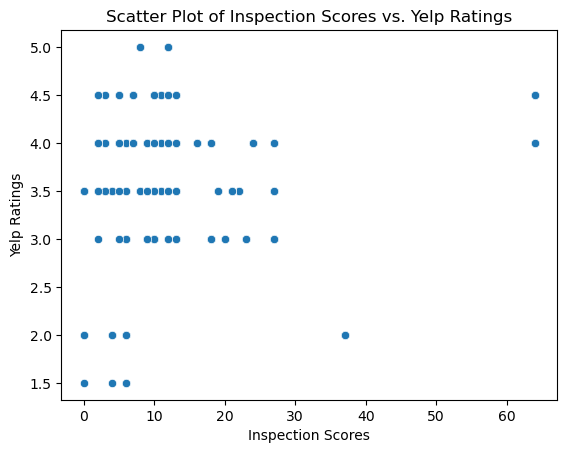

In [20]:
sns.scatterplot(x=merged_df['SCORE'], y=merged_df['rating'])
plt.title('Scatter Plot of Inspection Scores vs. Yelp Ratings')
plt.xlabel('Inspection Scores')
plt.ylabel('Yelp Ratings')
plt.show()

## **Feature Engineering**

- Find out if there is a significant correlation between certain violations for certain restaurant types of specific areas/boros.

- Most common violations for each restaurant type and each set of chains if applicable for each boro.

- Do corporate restaurants or privately owned places get better scores/grades? What are the most common violations that cost the most points on the inspections.

- Construct predictive models to predict when initial and re-inspections are going to happen

- Construct predictive models to predict which restaurants will pass/fail inspections.

- Find out if there is correlation between a higher score/grade causing a restaurant to recive an overall better score on yelp. Look at the comparison between the results for coporate and privately owned places.

## **Test weather there is a coorelation between average price per meal and inspection scores**